<a href="https://colab.research.google.com/github/mrella/finance/blob/main/best_stocks_morningstar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ENTORNO

In [1]:
!pip install mstarpy

In [2]:
!pip install fuzzywuzzy

In [3]:
import requests
import mstarpy
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_theme(style="darkgrid", palette="muted", font_scale=1.1)

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
headers = {"Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,\
           */*;q=0.8",
           "Accept-Encoding": "gzip, deflate, sdch, br",
           "Accept-Language": "en-US,en;q=0.8,es-ES;q=0.5,es;q=0.3",
           "Cache-Control": "no-cache", "dnt": "1",
           "Pragma": "no-cache",
           "Upgrade-Insecure-Requests": "1",
           "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:93.0)\
           Gecko/20100101 Firefox/93.0"}

#CÓDIGO

In [5]:
#OBTENCIÓN DE LOS DATOS DE FONDOS EN BRUTO
secids = []
names = []
returns = []
holdings = []
for page in range(1, 3):
  url = 'https://lt.morningstar.com/api/rest.svc/klr5zyak8x/security/screener?page=' + str(page) + '&pageSize=50&sortOrder=ReturnM120%20desc&outputType=json&version=1&languageId=es-ES&currencyId=EUR&universeIds=FOESP%24%24ALL&securityDataPoints=SecId%7CName%7CPriceCurrency%7CTenforeId%7CLegalName%7CClosePrice%7CYield_M12%7CCategoryName%7CAnalystRatingScale%7CStarRatingM255%7CQuantitativeRating%7CSustainabilityRank%7CReturnD1%7CReturnW1%7CReturnM1%7CReturnM3%7CReturnM6%7CReturnM0%7CReturnM12%7CReturnM36%7CReturnM60%7CReturnM120%7CFeeLevel%7CManagerTenure%7CMaxDeferredLoad%7CInitialPurchase%7CFundTNAV%7CEquityStyleBox%7CBondStyleBox%7CAverageMarketCapital%7CAverageCreditQualityCode%7CEffectiveDuration%7CMorningstarRiskM255%7CAlphaM36%7CBetaM36%7CR2M36%7CStandardDeviationM36%7CSharpeM36%7CTrackRecordExtension&filters=&term=&subUniverseId='
  req = requests.get(url, headers=headers)
  funds_json = req.json()
  for row in funds_json['rows']:
    category = row['CategoryName']
    if 'RV' in category:
      secid = row['SecId']
      secids.append(secid)
      name = row['LegalName']
      names.append(name)
      return120 = row['ReturnM120']
      returns.append(return120)
      fund = mstarpy.Funds(term=secid)
      df = fund.holdings(holdingType="equity")
      df = df[df['country']=='United States']
      df = df.head(10)
      holdings.append(df['ticker'].tolist())

df_funds = pd.DataFrame({'Id': secids, 'Fund': names, 'Return10A': returns, 'Stocks': holdings})
df_funds.head(5)

,Id,Fund,Return10A,Stocks
0,F000001ZFE,JPMorgan Funds - US Technology Fund C (acc) - USD,19.29,"[NFLX, SNOW, TTWO, NOW, META, NVDA, HOOD, INTU..."
1,F00000PASZ,JPMorgan Funds - US Technology Fund C (dist) -...,19.28,"[NFLX, SNOW, TTWO, NOW, META, NVDA, HOOD, INTU..."
2,F000001ATI,Fidelity Funds - Global Technology Fund Y-Acc-EUR,18.97,"[MSFT, AAPL, AMZN, MCHP, GOOGL, TXN, WDAY, MET..."
3,F00000QIPH,Fidelity Funds - Global Technology Fund Y-DIST...,18.97,"[MSFT, AAPL, AMZN, MCHP, GOOGL, TXN, WDAY, MET..."
4,F00000QM7C,Janus Henderson Capital Funds plc - Global Tec...,18.62,"[MSFT, NVDA, AVGO, AAPL, AMZN, META, CDNS]"


In [6]:
#LIMPIADO DE DUPLICADOS DE FONDOS CON VARIAS CLASES
funds_list = df_funds['Fund'].tolist()
i = 0
while i < len(funds_list):
  j = i + 1
  while j < len(funds_list):
    similarity_ratio = fuzz.ratio(funds_list[i], funds_list[j])
    if similarity_ratio > 85:
      del funds_list[j]
    else:
      j += 1
  i += 1
df_funds = df_funds[df_funds['Fund'].isin(funds_list)]
df_funds.head(5)

,Id,Fund,Return10A,Stocks
0,F000001ZFE,JPMorgan Funds - US Technology Fund C (acc) - USD,19.29,"[NFLX, SNOW, TTWO, NOW, META, NVDA, HOOD, INTU..."
2,F000001ATI,Fidelity Funds - Global Technology Fund Y-Acc-EUR,18.97,"[MSFT, AAPL, AMZN, MCHP, GOOGL, TXN, WDAY, MET..."
4,F00000QM7C,Janus Henderson Capital Funds plc - Global Tec...,18.62,"[MSFT, NVDA, AVGO, AAPL, AMZN, META, CDNS]"
6,0P0000VHOL,BlackRock Global Funds - World Technology Fund...,18.45,"[NVDA, MSFT, AVGO, AAPL, META, AMZN, ORCL, SNO..."
9,F000005H0E,Polar Capital Funds PLC - Polar Capital Global...,18.32,"[NVDA, META, AVGO, NET, CYBR, SPOT, NFLX, GEV,..."


In [7]:
#LIMPIADO DE FONDOS SIN ACCIONES AMERICANAS
df_funds['Stocks'] = np.where(df_funds['Stocks'].apply(len) > 0, df_funds['Stocks'], None)
df_funds = df_funds.dropna()
df_funds.head(5)

,Id,Fund,Return10A,Stocks
0,F000001ZFE,JPMorgan Funds - US Technology Fund C (acc) - USD,19.29,"[NFLX, SNOW, TTWO, NOW, META, NVDA, HOOD, INTU..."
2,F000001ATI,Fidelity Funds - Global Technology Fund Y-Acc-EUR,18.97,"[MSFT, AAPL, AMZN, MCHP, GOOGL, TXN, WDAY, MET..."
4,F00000QM7C,Janus Henderson Capital Funds plc - Global Tec...,18.62,"[MSFT, NVDA, AVGO, AAPL, AMZN, META, CDNS]"
6,0P0000VHOL,BlackRock Global Funds - World Technology Fund...,18.45,"[NVDA, MSFT, AVGO, AAPL, META, AMZN, ORCL, SNO..."
9,F000005H0E,Polar Capital Funds PLC - Polar Capital Global...,18.32,"[NVDA, META, AVGO, NET, CYBR, SPOT, NFLX, GEV,..."


In [8]:
#OBTENCIÓN DE LA LISTA CON TODAS LAS APARICIONES
stocks_list = df_funds['Stocks'].tolist()
stocks_list = [element for sublist in stocks_list for element in sublist]

In [9]:
#RECUENTO DE APARICIONES
df_stocks = pd.DataFrame({'Stock': stocks_list})
df_stocks = df_stocks['Stock'].value_counts().reset_index()
df_stocks.columns = ['Stock', 'Appearances']
df_stocks.head(10)

,Stock,Appearances
0,META,22
1,NVDA,20
2,MSFT,18
3,AMZN,17
4,AAPL,14
5,AVGO,12
6,GOOGL,10
7,MA,9
8,NFLX,9
9,TSLA,6


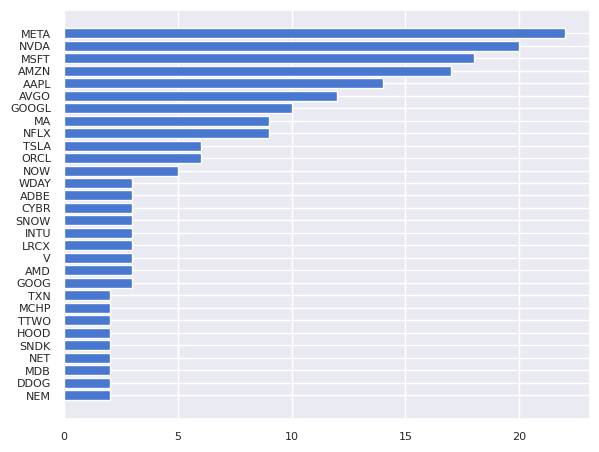

In [11]:
#VISUALIZACIÓN
plt.barh(df_stocks['Stock'].head(30), df_stocks['Appearances'].head(30))
plt.gca().invert_yaxis()
plt.tight_layout()
# Reducir tamaño de letra de los ejes
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()